In [1]:
import cv2 as cv
import cv2
from PIL import Image
import numpy as np
#from google.colab.patches import cv2_imshow
import math
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage.measure import label
from sklearn.feature_extraction import image

In [2]:
def cv2_imshow(img):
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_img)
    plt.show()

In [3]:
def get_color_clusters(im, n_clusters=2):
    # im: numpy array of a 3-channel image
    colors = im.reshape(-1,3)  # a list of all the pixel colors in the image
    kmeans = KMeans(n_clusters=n_clusters).fit(colors)
    # ^ KMeans() is from sklearn.cluster
    kmap = kmeans.labels_.copy().reshape(im.shape[0:2])  # an image where each pixel is replaced by its kmeans label
    clusters, num_clusters = label(kmap, connectivity=1, background=-1, return_num=True)  # an image where each pixel is replaced by its cluster label
    # ^ label() is from skimage.measure
    all_clusters = [np.transpose(np.where(clusters==n)) for n in range(num_clusters)]  # a list of the coordinates of pixels in each cluster
    return all_clusters, clusters, kmap, num_clusters

In [4]:
def show_cluster(px, shape):
    arr = np.zeros(shape)
    for i,j in px:
        arr[i,j] = 255
    plt.matshow(arr)

In [5]:
def show_many_clusters(clusters, shape):
    arr = np.zeros(shape)
    for i, cluster in enumerate(clusters):
        for r,c in cluster:
            arr[r,c] = i+1
    plt.matshow(arr)
    plt.show()

In [6]:
def cluster_to_img(cluster, shape):
    arr = np.zeros(shape)
    for r, c in cluster:
        arr[r,c] = 255
    return arr.astype(np.uint8)

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!ls drive/Shareddrives/TEAM\ 9:\ Aerobatic\ BlackBox/Image\ Analysis

 airspeed_dial_detection_2.ipynb  'Test image 1.gdraw'
 airspeed_dial_detection.ipynb	  'Test image 1.png'
'method2 - dial.ipynb'		  'Test image 2.jpeg'
 real_dial.png			   testing.ipynb
 res1.png			  'Untitled presentation.gslides'
'Rudder cable test 1.gdraw'


In [9]:
FOLDER_PREFIX = 'drive/Shareddrives/TEAM 9: Aerobatic BlackBox/Image Analysis/'

In [10]:
img_shape = (800,600)

img = Image.open('drive/Shareddrives/TEAM 9: Aerobatic BlackBox/Image Analysis/real_dial.png').resize(img_shape)
#img = img.transpose(Image.ROTATE_270)
#img = Image.open('real_dial.png').resize(img_shape)

#img = cv.imread(cv.samples.findFile(FOLDER_PREFIX+'real_dial.png'), cv.IMREAD_COLOR)
#img = cv2.rotate(img, cv2.cv2.ROTATE_90_CLOCKWISE)#.resize(img_shape)

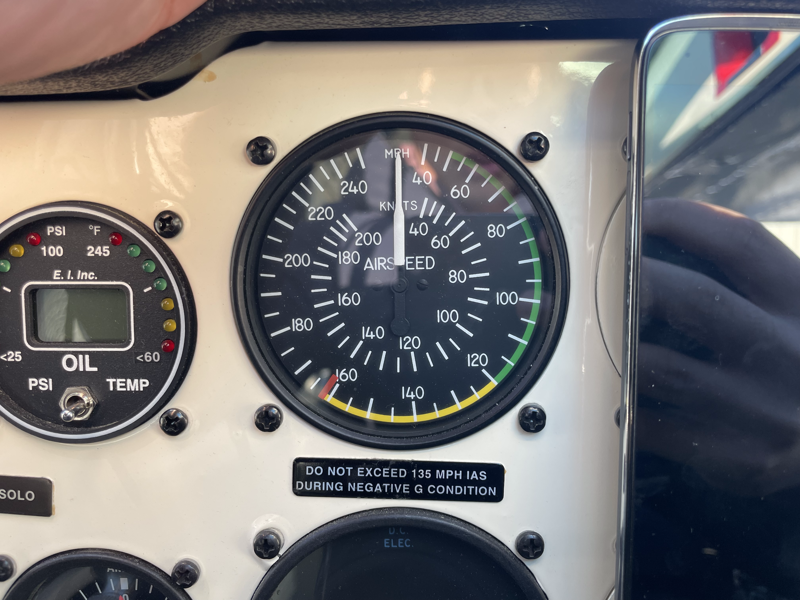

In [13]:
#cv2_imshow(img)
img

In [12]:
type(img)

PIL.Image.Image

In [ ]:
img_shape = (800,600)

In [ ]:
img_shape = (600,800)
img = img.resize(img_shape)

In [ ]:
#img = img2

In [14]:
im = np.array(img)

In [15]:
im.shape  # original

(600, 800, 3)

In [ ]:
im.shape  # rotated

(800, 600, 3)

In [ ]:
img

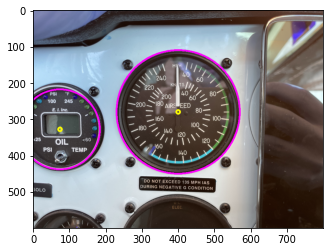

In [16]:
# find the circles
gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
rows = gray.shape[0]
circles = cv.HoughCircles(gray, cv.HOUGH_GRADIENT, 1, minDist=rows / 8,
                            param1=300, param2=100,
                            minRadius=int(rows/8), maxRadius=500)
# circles = cv.HoughCircles(img,cv.HOUGH_GRADIENT,1,20,
#                             param1=50,param2=30,minRadius=0,maxRadius=0)

if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        center = (i[0], i[1])
        # circle center
        cv.circle(im, center, 5, (0, 255, 255), 3)
        # circle outline
        radius = i[2]
        cv.circle(im, center, radius, (255, 0, 255), 3)
else:
    print("no circles")


cv2_imshow(im)

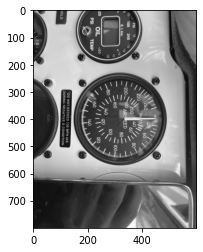

In [ ]:
cv2_imshow(gray)

In [17]:
circles  # these are column, row, radius values

array([[[400, 280, 170],
        [ 74, 328, 110]]], dtype=uint16)

In [20]:
userpoint = [390, 270]#[::-1]

In [21]:
# get circle containing userpoint
for col, row, rad in circles[0]:
  if (userpoint[0]-col)**2 + (userpoint[1]-row)**2 < rad**2:
    circle = [col, row, rad]

In [22]:
# 1st circle is the one we want, we can have the user select the correct circle
#circle = circles[0,0]
circle

[400, 280, 170]

In [23]:
# get the bounds of the circle
colbounds = [circle[0]-circle[2], circle[0]+circle[2]]
rowbounds = [circle[1]-circle[2], circle[1]+circle[2]]
circlecenter = [circle[1], circle[0]]  # this is in [row, col] order

In [ ]:
# get clusters of similarly colored pixles, and choose the ones inside the circle bounds

In [24]:
#im = np.array(img)
all_clusters, clusters, kmap, _ = get_color_clusters(im, n_clusters=3)

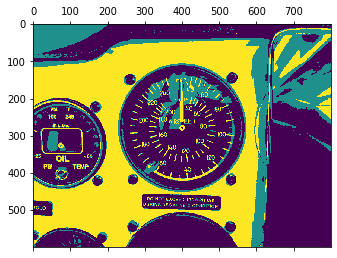

In [25]:
plt.matshow(kmap)

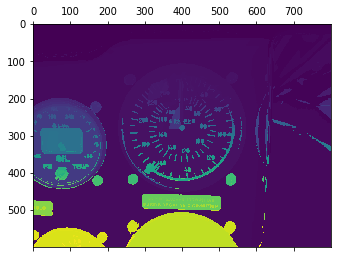

In [26]:
plt.matshow(clusters)

In [ ]:
all_clusters[2]

array([[  0, 206],
       [  0, 207],
       [  0, 208],
       ...,
       [103, 630],
       [103, 631],
       [104, 631]])

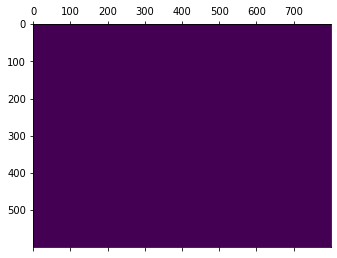

In [ ]:
show_cluster(all_clusters[4], img_shape)

In [27]:
def is_cluster_in_bounds(cluster, rowbounds, colbounds):
    try:
        cluster_rowmin = np.min(cluster[:,0])
        cluster_rowmax = np.max(cluster[:,0])
        cluster_colmin = np.min(cluster[:,1])
        cluster_colmax = np.max(cluster[:,1])
        cluster_center = [np.mean(cluster[:,0]), np.mean(cluster[:,1])]
        if cluster_rowmin > rowbounds[0] and cluster_rowmax < rowbounds[1] \
        and cluster_colmin > colbounds[0] and cluster_colmax < colbounds[1]:
            return True
        return False
    except:
        return False

In [31]:
filtered_clusters = [c for c in all_clusters if len(c) > 100 and is_cluster_in_bounds(c, rowbounds, colbounds)]

In [32]:
print(f"{len(filtered_clusters)} of {len(all_clusters)} are in the bounds and large")

28 of 4306 are in the bounds and large


In [ ]:
img_shape

(800, 600)

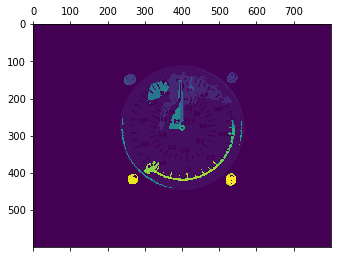

In [34]:
img_shape = (600,800)
show_many_clusters(filtered_clusters, img_shape)

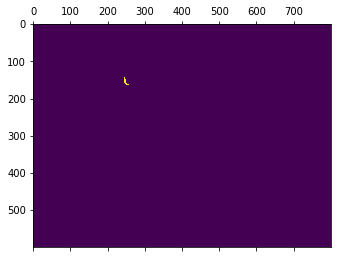

In [ ]:
test = cluster_to_img(filtered_clusters[7], img_shape)
plt.matshow(test)

In [35]:
all_lines = []
line_clusters = []
for i, cluster in enumerate(filtered_clusters):
    #cv.imwrite(f"cluster_{i}.png", cluster_to_img(cluster, img_shape))
    #cv_cluster = cv.imread()
    lines = cv.HoughLines(cluster_to_img(cluster, img_shape), 1, 0.01, int(3000/np.sqrt(len(cluster))))
    try:
        print(lines.shape)
    except:
        pass
    if lines is not None:
        all_lines.append(lines[0])
        line_clusters.append(cluster)

(10667, 1, 2)
(3835, 1, 2)
(14, 1, 2)
(2, 1, 2)


In [36]:
len(all_lines)

4

In [37]:
len(line_clusters)

4

In [38]:
all_lines

[array([[462.  ,   1.03]], dtype=float32),
 array([[-46.  ,   2.03]], dtype=float32),
 array([[397.,   0.]], dtype=float32),
 array([[565.  ,   1.11]], dtype=float32)]

In [42]:
#background = cv.imread(cv.samples.findFile(FOLDER_PREFIX+'res1.png'), cv.IMREAD_COLOR)
#background = cv2.rotate(background, cv2.cv2.ROTATE_90_CLOCKWISE)
background = np.array(img)

if all_lines:
    #for lines in all_lines:
    lines = all_lines
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv.line(background, pt1, pt2, (0,0,255), 3, cv.LINE_AA)
else:
    print("no lines")

In [43]:
cv.circle(background, tuple(circlecenter[::-1]), 5, (0, 255, 255), 3)
1

1

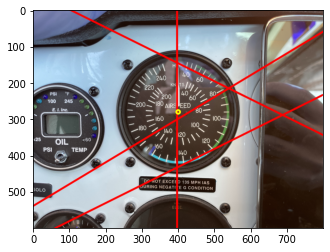

In [44]:
cv2_imshow(background)

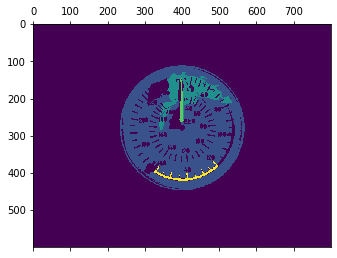

In [45]:
show_many_clusters(line_clusters, img_shape)

Only one of these lines is closest to the center of the circle: this must be the dial

In [69]:
def plot_line_on_cluster(line, background):
  background = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)
  rho = line[0][0]
  theta = line[0][1]
  a = math.cos(theta)
  b = math.sin(theta)
  x0 = a * rho
  y0 = b * rho
  pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
  pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
  cv.line(background, pt1, pt2, (0,0,255), 3, cv.LINE_AA)
  cv2_imshow(background)

In [46]:
from math import pi

def lineness_metric(cluster, n_buckets=30):
  # get the variance of frequencies of angles of pixels around the center
  # circles -> low variance, lines -> high variance
  cluster = np.array(cluster)  # just in case
  center = [np.mean(cluster[:,0]), np.mean(cluster[:,1])]
  de_meaned = cluster - center
  angles = np.array([np.arctan2(o, a) for o,a in de_meaned])
  #print(angles[:20])
  angle_freqs = np.histogram(angles, bins=n_buckets, range=(-pi, pi))[0]
  #print(angle_freqs)
  scaled_angle_freqs = angle_freqs/len(angles)
  #print(scaled_angle_freqs)
  return np.std(scaled_angle_freqs), scaled_angle_freqs

0.007368068025185563


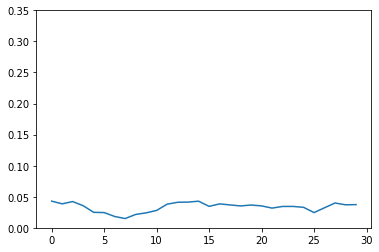

In [65]:
metric, freqs = lineness_metric(line_clusters[0], 30)
print(metric)
plt.plot(freqs)
plt.ylim(0, 0.35)
plt.show()

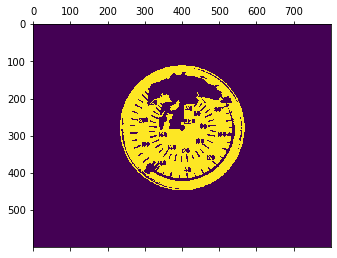

In [48]:
show_cluster(line_clusters[0], img_shape)

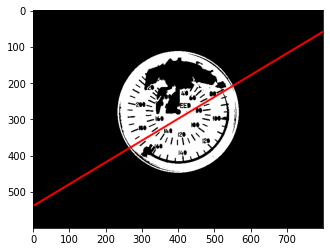

In [70]:
plot_line_on_cluster(all_lines[0], cluster_to_img(line_clusters[0], img_shape))

0.021570829344211076


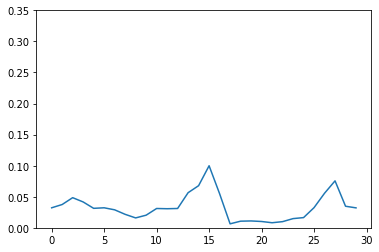

In [64]:
metric, freqs = lineness_metric(line_clusters[1], 30)
print(metric)
plt.plot(freqs)
plt.ylim(0, 0.35)
plt.show()

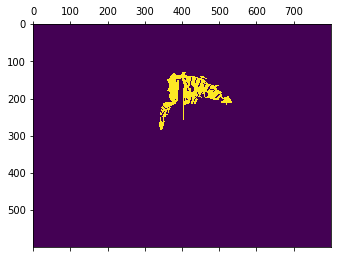

In [50]:
show_cluster(line_clusters[1], img_shape)

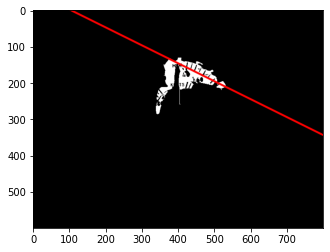

In [71]:
plot_line_on_cluster(all_lines[1], cluster_to_img(line_clusters[1], img_shape))

0.074254985022789


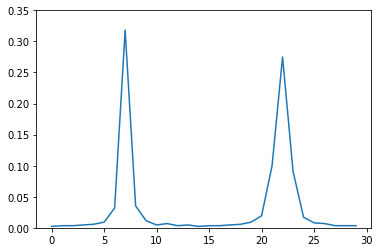

In [63]:
metric, freqs = lineness_metric(line_clusters[2], 30)
print(metric)
plt.plot(freqs)
plt.ylim(0, 0.35)
plt.show()

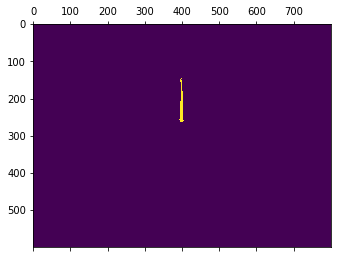

In [52]:
show_cluster(line_clusters[2], img_shape)

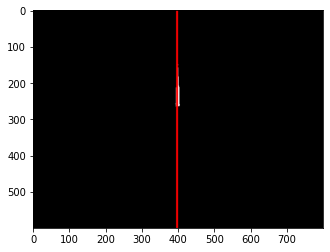

In [72]:
plot_line_on_cluster(all_lines[2], cluster_to_img(line_clusters[2], img_shape))

0.04438885137533243


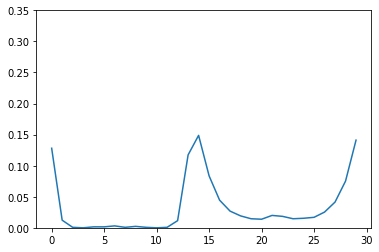

In [62]:
metric, freqs = lineness_metric(line_clusters[3], 30)
print(metric)
plt.plot(freqs)
plt.ylim(0, 0.35)
plt.show()

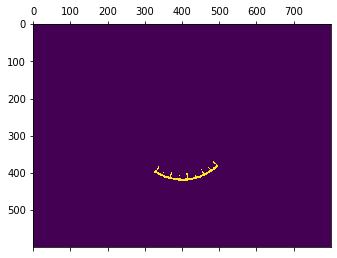

In [54]:
show_cluster(line_clusters[3], img_shape)

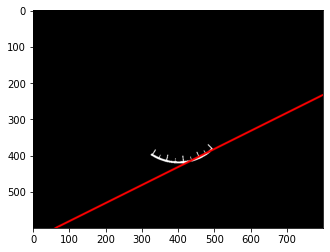

In [73]:
plot_line_on_cluster(all_lines[3], cluster_to_img(line_clusters[3], img_shape))

In [55]:
linenesses = [lineness_metric(cluster)[0] for cluster in line_clusters]

In [56]:
linenesses

[0.007368068025185563,
 0.021570829344211076,
 0.074254985022789,
 0.04438885137533243]

In [57]:
np.argmax(linenesses)

2

In [58]:
best_line = all_lines[np.argmax(linenesses)]

In [59]:
best_line

array([[397.,   0.]], dtype=float32)

In [ ]:
background = np.array(img)

rho = best_line[0][0]
theta = best_line[0][1]
a = math.cos(theta)
b = math.sin(theta)
x0 = a * rho
y0 = b * rho
pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
cv.line(background, pt1, pt2, (0,0,255), 3, cv.LINE_AA)


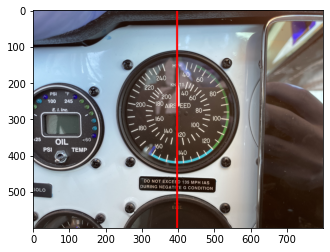

In [61]:
cv2_imshow(background)

In [ ]:
angle = best_line[0][1]

In [ ]:
print(f"The angle is {angle} radians from vertical, increasing clockwise")

The angle is 1.5199999809265137 radians from vertical, increasing clockwise


In [ ]:
pi/2

1.5707963267948966

In [ ]:
type(img)

PIL.Image.Image

In [ ]:
img.size

(600, 800)

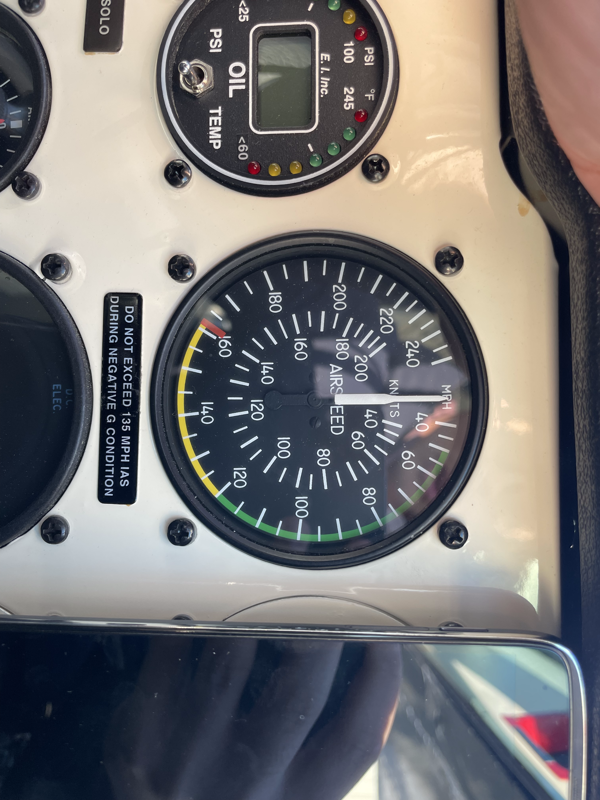

In [ ]:
img